<b>CSC 522 Automated Learning and Data Analysis</b><br>
Project Group: 14 : {agmalpur}, {rkulkar5}, {radange}<br>
Title: Customer Churn Prediction using Telco Customer Churn Dataset

In [1]:
#importing all required libraries
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle

import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(2024)
random.seed(2024)

<h2> Understanding the Data

In [4]:
#Reading the Dataset from local source
df=pd.read_csv(r'D:\NCSU\Fall 2024\ALDA\Project\Telco_Customer_Churn_with_NaNs.csv')
#Splitting the data into train and test sets (70% train data and 30% test data)
train, test = train_test_split(df, test_size=0.3, random_state=2024)
test=test.drop('Churn', axis=1) #dropping the 'Churn' column in test data to predict the results

In [5]:
train.shape #checking the shape of the training data

(4930, 21)

In [6]:
train.head() #glancing at the training data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4097,9974-JFBHQ,Male,0.0,No,Yes,64.0,Yes,No,Fiber optic,No,...,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),NaN,6171.2,No
1688,4735-BJKOU,Female,0.0,No,No,40.0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.15,804.85,No
6215,2446-BEGGB,Female,NaN,No,No,6.0,Yes,Yes,Fiber optic,No,...,No,No,Yes,NaN,Month-to-month,NaN,Electronic check,NaN,560.6,Yes
5828,0402-OAMEN,Female,0.0,Yes,Yes,72.0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),24.45,1709.1,No
5586,1998-VHJHK,Female,0.0,No,No,27.0,Yes,NaN,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,NaN,19.15,501.35,No


In [7]:
train.info() #getting insights upon the training data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4930 entries, 4097 to 3578
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4930 non-null   object 
 1   gender            4691 non-null   object 
 2   SeniorCitizen     4701 non-null   float64
 3   Partner           4703 non-null   object 
 4   Dependents        4661 non-null   object 
 5   tenure            4700 non-null   float64
 6   PhoneService      4679 non-null   object 
 7   MultipleLines     4695 non-null   object 
 8   InternetService   4683 non-null   object 
 9   OnlineSecurity    4698 non-null   object 
 10  OnlineBackup      4651 non-null   object 
 11  DeviceProtection  4660 non-null   object 
 12  TechSupport       4668 non-null   object 
 13  StreamingTV       4702 non-null   object 
 14  StreamingMovies   4669 non-null   object 
 15  Contract          4677 non-null   object 
 16  PaperlessBilling  4691 non-null   objec

In [8]:
#getting the overall statistics for the training data 
train.describe(include='all').transpose()
#describe by default will only give values of numerical attributes, 'inlcude all' will also include categorical features.

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,4930,4930,4822-NGOCH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,4691,2,Male,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,4701.0,NaN,NaN,NaN,0.160817,0.367401,0.0,0.0,0.0,0.0,1.0
Partner,4703,2,No,2424,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,4661,2,No,3272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,4700.0,NaN,NaN,NaN,32.364043,24.453534,0.0,9.0,29.0,55.0,72.0
PhoneService,4679,2,Yes,4238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,4695,3,No,2254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,4683,3,Fiber optic,2084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,4698,3,No,2350,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
test.shape #getting the shape of the test dataset 

(2113, 20)

In [10]:
test.head() #glancing over the test data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
825,2311-QYMUQ,Female,0.0,Yes,Yes,16.0,Yes,No,Fiber optic,No,NaN,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.45,1430.25
6768,9739-JLPQJ,Female,0.0,Yes,Yes,72.0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),117.50,8670.1
2274,0320-JDNQG,Male,0.0,Yes,NaN,23.0,Yes,No,Fiber optic,Yes,No,No,Yes,NaN,Yes,Month-to-month,Yes,Electronic check,99.85,2331.3
2580,7748-UMTRK,Female,1.0,No,Yes,30.0,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,101.30,2974.5
4206,0017-IUDMW,Female,0.0,Yes,Yes,NaN,NaN,NaN,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),116.80,8456.75


In [11]:
test.info() #getting to learn about the test data by getting its information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2113 entries, 825 to 6375
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2113 non-null   object 
 1   gender            2021 non-null   object 
 2   SeniorCitizen     2018 non-null   float64
 3   Partner           1984 non-null   object 
 4   Dependents        2010 non-null   object 
 5   tenure            2009 non-null   float64
 6   PhoneService      2011 non-null   object 
 7   MultipleLines     2002 non-null   object 
 8   InternetService   2020 non-null   object 
 9   OnlineSecurity    1998 non-null   object 
 10  OnlineBackup      1997 non-null   object 
 11  DeviceProtection  1998 non-null   object 
 12  TechSupport       1996 non-null   object 
 13  StreamingTV       1995 non-null   object 
 14  StreamingMovies   2014 non-null   object 
 15  Contract          2014 non-null   object 
 16  PaperlessBilling  2005 non-null   object

In [12]:
test.describe(include='all').transpose() #looking at the statistics of the test data

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,2113,2113,9894-EZEWG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,2021,2,Male,1023,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,2018.0,NaN,NaN,NaN,0.16551,0.371733,0.0,0.0,0.0,0.0,1.0
Partner,1984,2,No,1028,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,2010,2,No,1402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,2009.0,NaN,NaN,NaN,32.870582,24.82886,0.0,9.0,29.0,57.0,72.0
PhoneService,2011,2,Yes,1805,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2002,3,No,962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,2020,3,Fiber optic,873,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,1998,3,No,974,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Checking for duplicates in the train dataset
train.duplicated().sum()

0

In [14]:
#Checking for duplicates in the test dataset
test.duplicated().sum()

0

In [15]:
#Finding the missing values in the train dataset
train.isna().sum()

customerID            0
gender              239
SeniorCitizen       229
Partner             227
Dependents          269
tenure              230
PhoneService        251
MultipleLines       235
InternetService     247
OnlineSecurity      232
OnlineBackup        279
DeviceProtection    270
TechSupport         262
StreamingTV         228
StreamingMovies     261
Contract            253
PaperlessBilling    239
PaymentMethod       240
MonthlyCharges      245
TotalCharges        236
Churn                 0
dtype: int64

In [16]:
#Finding the missing values in the test dataset
test.isna().sum()

customerID            0
gender               92
SeniorCitizen        95
Partner             129
Dependents          103
tenure              104
PhoneService        102
MultipleLines       111
InternetService      93
OnlineSecurity      115
OnlineBackup        116
DeviceProtection    115
TechSupport         117
StreamingTV         118
StreamingMovies      99
Contract             99
PaperlessBilling    108
PaymentMethod       116
MonthlyCharges      106
TotalCharges        105
dtype: int64

In [17]:
#Splitting the features upon the target variable output and getting the count (training data)
print('OnlineSecurity: ')
print(train['OnlineSecurity'].value_counts())
print('\n Gender: ')
print(train['gender'].value_counts())
print('\n Senior Citizen: ')
print(train['SeniorCitizen'].value_counts())
print('\n Partner: ')
print(train['Partner'].value_counts())
print('\n Payment Method: ')
print(train['PaymentMethod'].value_counts())
print('\n Contract: ')
print(train['Contract'].value_counts())
print('\n Streaming Movies: ')
print(train['StreamingMovies'].value_counts())
print('\n Tech Support:')
print(train['TechSupport'].value_counts())
print('\n Paperless Billing: ')
print(train['PaperlessBilling'].value_counts())
print('\n Streamming TV: ')
print(train['StreamingTV'].value_counts())
print('\n Device Protection: ')
print(train['DeviceProtection'].value_counts())
print('\n Churn: ')
print(train['Churn'].value_counts())

OnlineSecurity: 
No                     2350
Yes                    1359
No internet service     989
Name: OnlineSecurity, dtype: int64

 Gender: 
Male      2369
Female    2322
Name: gender, dtype: int64

 Senior Citizen: 
0.0    3945
1.0     756
Name: SeniorCitizen, dtype: int64

 Partner: 
No     2424
Yes    2279
Name: Partner, dtype: int64

 Payment Method: 
Electronic check             1600
Mailed check                 1077
Bank transfer (automatic)    1021
Credit card (automatic)       992
Name: PaymentMethod, dtype: int64

 Contract: 
Month-to-month    2574
Two year          1103
One year          1000
Name: Contract, dtype: int64

 Streaming Movies: 
No                     1853
Yes                    1837
No internet service     979
Name: StreamingMovies, dtype: int64

 Tech Support:
No                     2314
Yes                    1378
No internet service     976
Name: TechSupport, dtype: int64

 Paperless Billing: 
Yes    2799
No     1892
Name: PaperlessBilling, dtype: int64

In [18]:
#Splitting the features upon the target variable output and getting the count (test data)
print('OnlineSecurity: ')
print(test['OnlineSecurity'].value_counts())
print('\n Gender: ')
print(test['gender'].value_counts())
print('\n Senior Citizen: ')
print(test['SeniorCitizen'].value_counts())
print('\n Partner: ')
print(test['Partner'].value_counts())
print('\n Payment Method: ')
print(test['PaymentMethod'].value_counts())
print('\n Contract: ')
print(test['Contract'].value_counts())
print('\n Streaming Movies: ')
print(test['StreamingMovies'].value_counts())
print('\n Tech Support:')
print(test['TechSupport'].value_counts())
print('\n Paperless Billing: ')
print(test['PaperlessBilling'].value_counts())
print('\n Streamming TV: ')
print(test['StreamingTV'].value_counts())
print('\n Device Protection: ')
print(test['DeviceProtection'].value_counts())

OnlineSecurity: 
No                     974
Yes                    556
No internet service    468
Name: OnlineSecurity, dtype: int64

 Gender: 
Male      1023
Female     998
Name: gender, dtype: int64

 Senior Citizen: 
0.0    1684
1.0     334
Name: SeniorCitizen, dtype: int64

 Partner: 
No     1028
Yes     956
Name: Partner, dtype: int64

 Payment Method: 
Electronic check             649
Mailed check                 453
Bank transfer (automatic)    448
Credit card (automatic)      447
Name: PaymentMethod, dtype: int64

 Contract: 
Month-to-month    1100
Two year           510
One year           404
Name: Contract, dtype: int64

 Streaming Movies: 
No                     781
Yes                    758
No internet service    475
Name: StreamingMovies, dtype: int64

 Tech Support:
No                     976
Yes                    557
No internet service    463
Name: TechSupport, dtype: int64

 Paperless Billing: 
Yes    1163
No      842
Name: PaperlessBilling, dtype: int64

 Streamming

In [19]:
#The number of categories in the target column (unique entries in the target column)
train['Churn'].unique()

array(['No', 'Yes'], dtype=object)

<h2> Visualization upon the Data 

<h4>Univariate Analysis

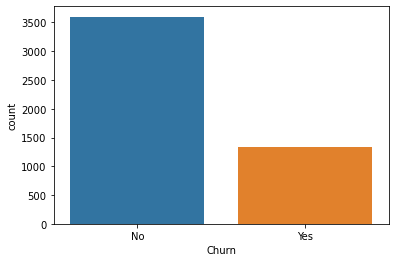

In [20]:
#The overall distribution of the categories in the Churn column in the training data visualized as a bar plot
sns.countplot(x='Churn', data=train)
plt.show()

In [21]:
#dropping the customerID feature since it is a nominal attribute and does not contribute to the understanding of whether a customer may churn or not.
train.drop(['customerID'], axis=1, inplace=True)
test.drop(['customerID'], axis=1, inplace=True)
#dropping the customerID feature in both train and test datasets
train['SeniorCitizen'] = train['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
test['SeniorCitizen'] = test['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

<function matplotlib.pyplot.show(close=None, block=None)>

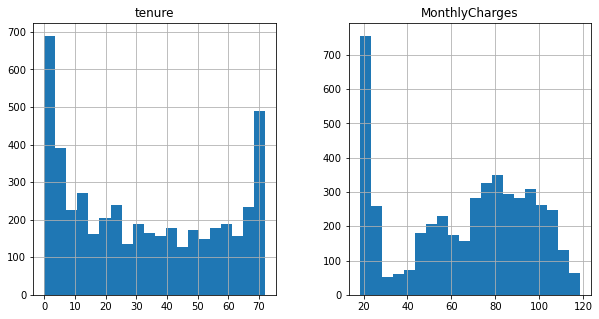

In [22]:
#plotting the histogram for numerical attributes to visualize the spread of values in it
train.hist(bins=20, figsize = (10,5))
plt.show
#TotalCharges is an object(ie. a categorical attribute) and therefore does not show up on one of these plots

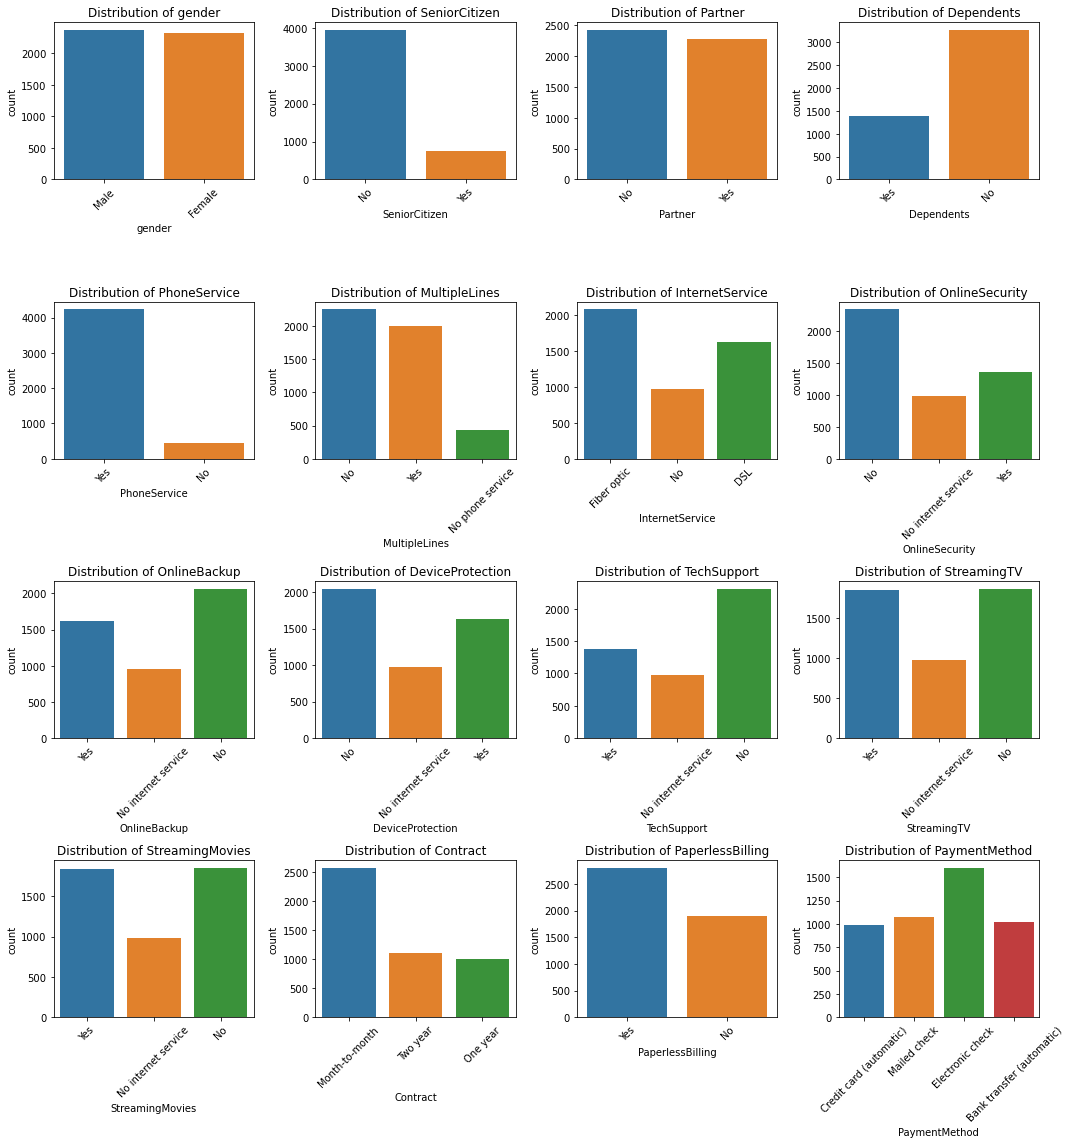

In [23]:
#plotting bar plots for all the categorical features in the dataset to visalize the overall spread of values in it

#categorical_columns stores all the categorical attributes in it, excluding attributes that have unique values in them (also the target variable)
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
categorical_columns = categorical_columns.drop(['TotalCharges','Churn']) 
num_cols = 4  #We want 4 plots per row
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  #calculating the total rows required
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4)) #creating subplots
axes = axes.flatten() #flattening axes

# Plotting bar graphs for each categorical column in the dataset
for i, col in enumerate(categorical_columns):
    sns.countplot(data=train, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Removing empty subplots
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

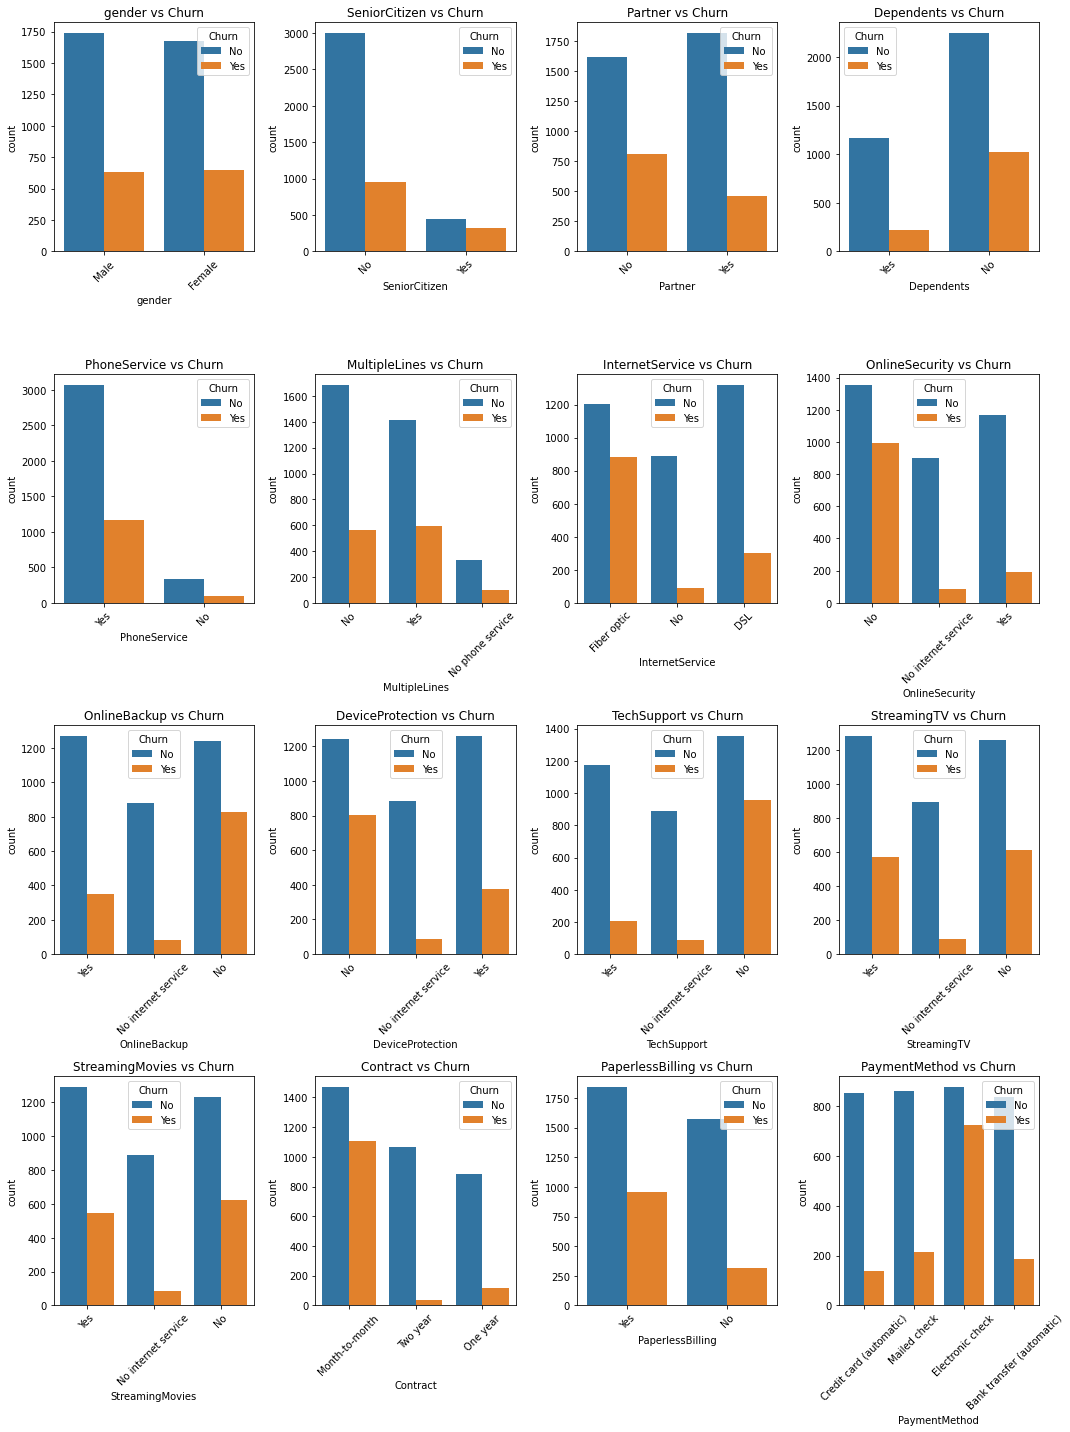

In [24]:
#Plotting bar graphs for the training dataset for attributes (to see the spread) according to the target variable Churn
num_cols = 4  #we require 4 plots per row
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculating the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5)) # making subplots
axes = axes.flatten() #flattening axes

# Plot bar graphs for each categorical column with 'Churn' (depicted by the different hues)
for i, col in enumerate(categorical_columns):
    sns.countplot(data=train, x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f'{col} vs Churn')
    axes[i].tick_params(axis='x', rotation=45)
for i in range(len(categorical_columns), len(axes)): #removing the subplots
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

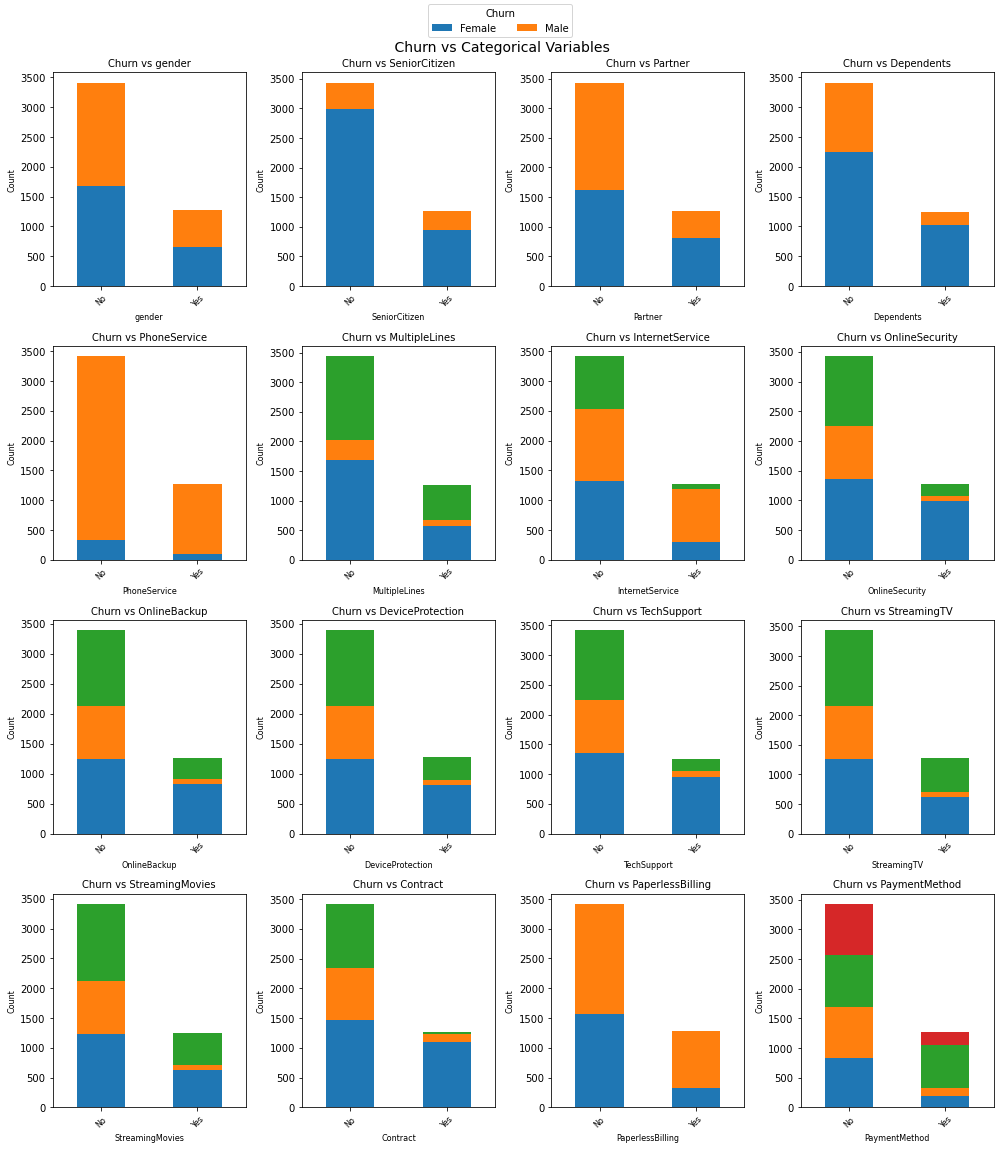

In [25]:
#idhar se karna hai comment-------------------------

# Assuming train is your DataFrame

# Step 1: Identify categorical columns (excluding 'Churn')
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
categorical_columns = categorical_columns.drop(['TotalCharges','Churn'])  # Exclude 'Churn'

# Step 2: Set the number of rows and columns for the grid
num_cols = 4  # You can adjust this value based on how many plots you want per row
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculate number of rows

# Step 3: Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 4))  # Adjust figure size
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Step 4: Loop through each categorical column and create a stacked bar chart
for i, col in enumerate(categorical_columns):
    cross_tab = pd.crosstab(train['Churn'], train[col])
    cross_tab.plot(kind='bar', stacked=True, ax=axes[i], legend=False)  # Remove legend for better clarity
    axes[i].set_title(f'Churn vs {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Count', fontsize=8)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=8)  # Adjust label rotation and size

# Step 5: Remove any unused subplots if needed
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

# Step 6: Adjust layout and add a single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Churn', loc='upper center', ncol=2, fontsize=10)

# Step 7: Final layout adjustments and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit everything including the legend
plt.suptitle('\n Churn vs Categorical Variables', fontsize=14)
plt.show()


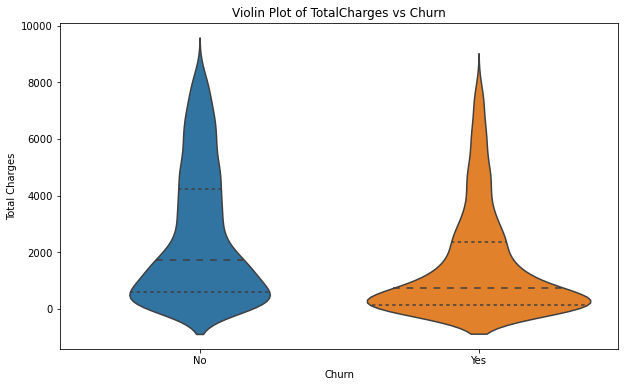

In [26]:
train['TotalCharges'] = pd.to_numeric(train['TotalCharges'], errors='coerce')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Churn', y='TotalCharges', data=train, inner='quartile')
plt.title('Violin Plot of TotalCharges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

<Figure size 720x432 with 0 Axes>

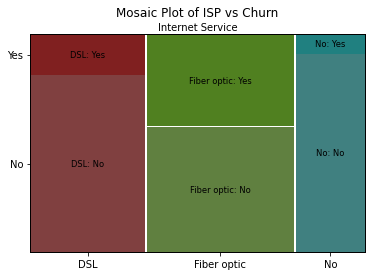

In [27]:
from statsmodels.graphics.mosaicplot import mosaic

# Assuming 'train' is your DataFrame
# Create a cross-tabulation of ISP and Churn
cross_tab = pd.crosstab(train['InternetService'], train['Churn'])

# Create the mosaic plot
plt.figure(figsize=(10, 6))
mosaic(cross_tab.stack(), title='Mosaic Plot of ISP vs Churn', labelizer=lambda k: f'{k[0]}: {k[1]}')
plt.xlabel('Internet Service')
plt.ylabel('Churn')
plt.show()

In [28]:
import plotly.graph_objects as go

# Assuming 'train' is your DataFrame

# Create a DataFrame to hold the counts for the Sankey diagram
sankey_data = train.groupby(['InternetService', 'Contract', 'PaymentMethod', 'Churn']).size().reset_index(name='Count')

# Create labels for the Sankey diagram
labels = (list(sankey_data['InternetService'].unique()) + 
          list(sankey_data['Contract'].unique()) + 
          list(sankey_data['PaymentMethod'].unique()) + 
          list(sankey_data['Churn'].unique()))

# Create a mapping for the labels to indices
label_index = {label: idx for idx, label in enumerate(labels)}

# Create source, target, and value lists for the Sankey diagram
sources = []
targets = []
values = []

# Populate the sources, targets, and values
for _, row in sankey_data.iterrows():
    internet_service_index = label_index[row['InternetService']]
    contract_index = label_index[row['Contract']] + len(sankey_data['InternetService'].unique())
    payment_method_index = (label_index[row['PaymentMethod']] + 
                            len(sankey_data['InternetService'].unique()) + 
                            len(sankey_data['Contract'].unique()))
    churn_index = (label_index[row['Churn']] + 
                   len(sankey_data['InternetService'].unique()) + 
                   len(sankey_data['Contract'].unique()) + 
                   len(sankey_data['PaymentMethod'].unique()))
    
    # First layer: InternetService to Contract
    sources.append(internet_service_index)
    targets.append(contract_index)
    values.append(row['Count'])
    
    # Second layer: Contract to PaymentMethod
    sources.append(contract_index)
    targets.append(payment_method_index)
    values.append(row['Count'])
    
    # Third layer: PaymentMethod to Churn
    sources.append(payment_method_index)
    targets.append(churn_index)
    values.append(row['Count'])

# Define colors for different categories
node_colors = []
for label in labels:
    if label in sankey_data['InternetService'].unique():
        node_colors.append('lightblue')  # InternetService color
    elif label in sankey_data['Contract'].unique():
        node_colors.append('lightgreen')  # Contract color
    elif label in sankey_data['PaymentMethod'].unique():
        node_colors.append('lightcoral')  # PaymentMethod color
    else:
        node_colors.append('green')  # Churn color

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors  # Apply colors here
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

# Add a title to the diagram
fig.update_layout(title_text="Sankey Diagram: Flow of Internet Service, Contract Type, Payment Method, and Customer Churn", font_size=10)
fig.show()

In [29]:
train.isna().sum()

gender              239
SeniorCitizen       229
Partner             227
Dependents          269
tenure              230
PhoneService        251
MultipleLines       235
InternetService     247
OnlineSecurity      232
OnlineBackup        279
DeviceProtection    270
TechSupport         262
StreamingTV         228
StreamingMovies     261
Contract            253
PaperlessBilling    239
PaymentMethod       240
MonthlyCharges      245
TotalCharges        242
Churn                 0
dtype: int64

In [30]:

train['SeniorCitizen'] = train['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
test['SeniorCitizen'] = test['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
train['DeviceProtection'] = train['DeviceProtection'].replace({'No': 'No internet service'})
test['DeviceProtection'] = test['DeviceProtection'].replace({'No': 'No internet service'})
train['MultipleLines'] = train['MultipleLines'].replace({'No': 'No phone service'})
test['MultipleLines'] = test['MultipleLines'].replace({'No': 'No phone service'})
train['OnlineBackup'] = train['OnlineBackup'].replace({'No': 'No internet service'})
test['OnlineBackup'] = test['OnlineBackup'].replace({'No': 'No internet service'})

train['OnlineSecurity'] = train['OnlineSecurity'].replace({'No': 'No internet service'})
test['OnlineSecurity'] = test['OnlineSecurity'].replace({'No': 'No internet service'})
train['TechSupport'] = train['TechSupport'].replace({'No': 'No internet service'})
test['TechSupport'] = test['TechSupport'].replace({'No': 'No internet service'})
train['StreamingTV'] = train['StreamingTV'].replace({'No': 'No internet service'})
test['StreamingTV'] = test['StreamingTV'].replace({'No': 'No internet service'})
train['StreamingMovies'] = train['StreamingMovies'].replace({'No': 'No internet service'})
test['StreamingMovies'] = test['StreamingMovies'].replace({'No': 'No internet service'})


In [31]:
train.isna().sum()

gender              239
SeniorCitizen       229
Partner             227
Dependents          269
tenure              230
PhoneService        251
MultipleLines       235
InternetService     247
OnlineSecurity      232
OnlineBackup        279
DeviceProtection    270
TechSupport         262
StreamingTV         228
StreamingMovies     261
Contract            253
PaperlessBilling    239
PaymentMethod       240
MonthlyCharges      245
TotalCharges        242
Churn                 0
dtype: int64

In [32]:
#CHange the data type of the Total Charges column
train['TotalCharges'] = train['TotalCharges'].replace(' ', np.nan)
#COnvert The total charges column into float
train["TotalCharges"]=train.TotalCharges.apply(lambda x:float(x))

In [33]:
#Change the data type of the Total charges column in the test data set
test['TotalCharges'] = test['TotalCharges'].replace(' ', np.nan)
#COnvert The total charges column into float
test["TotalCharges"]=test.TotalCharges.apply(lambda x:float(x))

In [34]:
#Checking for missing values
train.isna().sum()

gender              239
SeniorCitizen       229
Partner             227
Dependents          269
tenure              230
PhoneService        251
MultipleLines       235
InternetService     247
OnlineSecurity      232
OnlineBackup        279
DeviceProtection    270
TechSupport         262
StreamingTV         228
StreamingMovies     261
Contract            253
PaperlessBilling    239
PaymentMethod       240
MonthlyCharges      245
TotalCharges        242
Churn                 0
dtype: int64

In [35]:
#The percentage of the missing values
(train.isna().sum()*100)/ len(train)

gender              4.847870
SeniorCitizen       4.645030
Partner             4.604462
Dependents          5.456389
tenure              4.665314
PhoneService        5.091278
MultipleLines       4.766734
InternetService     5.010142
OnlineSecurity      4.705882
OnlineBackup        5.659229
DeviceProtection    5.476673
TechSupport         5.314402
StreamingTV         4.624746
StreamingMovies     5.294118
Contract            5.131846
PaperlessBilling    4.847870
PaymentMethod       4.868154
MonthlyCharges      4.969574
TotalCharges        4.908722
Churn               0.000000
dtype: float64

## Imputing the Missing Values

In [36]:
#Imputing the numerical columns using mean
numerical_imputer = SimpleImputer(strategy='mean')

In [37]:
#Numerical Columns
numerical_columns = ['tenure', 'TotalCharges','MonthlyCharges']


In [38]:
#Imputing the numerical columns in the train dataset
for column in numerical_columns:
    train[column] = numerical_imputer.fit_transform(train[column].values.reshape(-1, 1))
    test[column] = numerical_imputer.fit_transform(test[column].values.reshape(-1, 1))

In [39]:
#To Impute the Categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_columns = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService' ,'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Contract','PaperlessBilling','PaymentMethod' ,'Churn']
for column in categorical_columns:
    train[column] = categorical_imputer.fit_transform(train[column].values.reshape(-1, 1))
categorical_columns_test = ['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService' ,'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
for column in categorical_columns_test:  
    test[column] = categorical_imputer.fit_transform(test[column].values.reshape(-1, 1))

In [40]:
train.isna().sum()

gender                0
SeniorCitizen       229
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 0
dtype: int64

In [41]:
test.isna().sum()

gender               0
SeniorCitizen       95
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
dtype: int64

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4930 entries, 4097 to 3578
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4930 non-null   object 
 1   SeniorCitizen     4701 non-null   object 
 2   Partner           4930 non-null   object 
 3   Dependents        4930 non-null   object 
 4   tenure            4930 non-null   float64
 5   PhoneService      4930 non-null   object 
 6   MultipleLines     4930 non-null   object 
 7   InternetService   4930 non-null   object 
 8   OnlineSecurity    4930 non-null   object 
 9   OnlineBackup      4930 non-null   object 
 10  DeviceProtection  4930 non-null   object 
 11  TechSupport       4930 non-null   object 
 12  StreamingTV       4930 non-null   object 
 13  StreamingMovies   4930 non-null   object 
 14  Contract          4930 non-null   object 
 15  PaperlessBilling  4930 non-null   object 
 16  PaymentMethod     4930 non-null   objec

In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2113 entries, 825 to 6375
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2113 non-null   object 
 1   SeniorCitizen     2018 non-null   object 
 2   Partner           2113 non-null   object 
 3   Dependents        2113 non-null   object 
 4   tenure            2113 non-null   float64
 5   PhoneService      2113 non-null   object 
 6   MultipleLines     2113 non-null   object 
 7   InternetService   2113 non-null   object 
 8   OnlineSecurity    2113 non-null   object 
 9   OnlineBackup      2113 non-null   object 
 10  DeviceProtection  2113 non-null   object 
 11  TechSupport       2113 non-null   object 
 12  StreamingTV       2113 non-null   object 
 13  StreamingMovies   2113 non-null   object 
 14  Contract          2113 non-null   object 
 15  PaperlessBilling  2113 non-null   object 
 16  PaymentMethod     2113 non-null   object

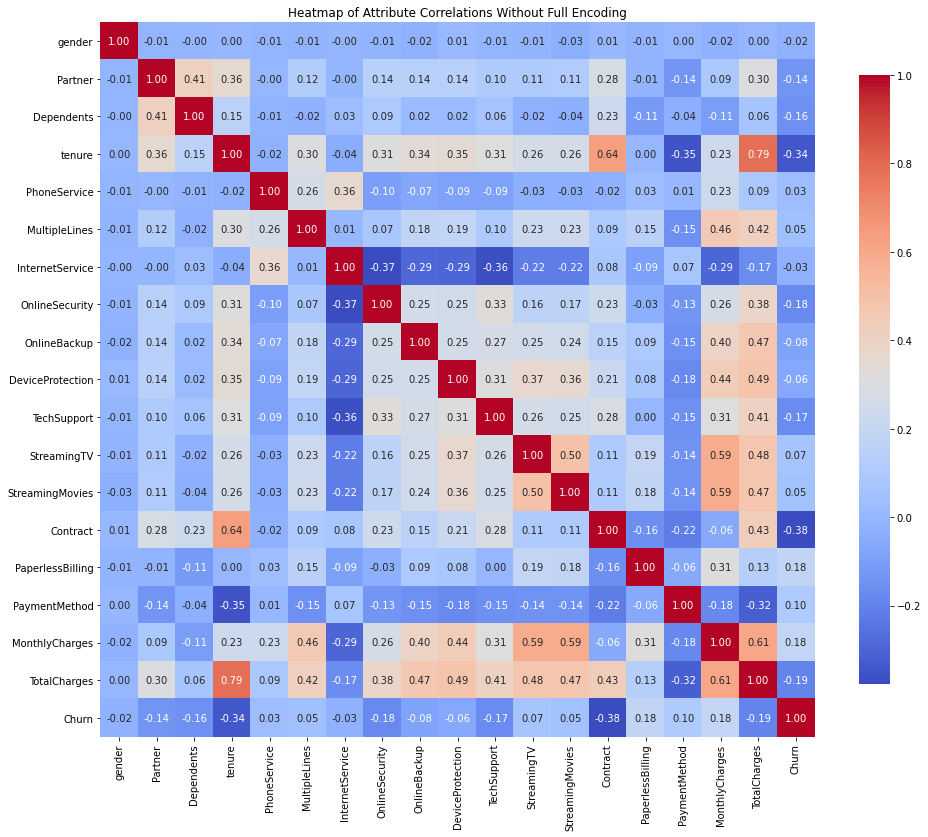

In [44]:

# Step 1: Convert categorical variables to numeric using label encoding
label_encoded = train.copy()
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                       'PaperlessBilling', 'PaymentMethod', 'Churn']

# Use label encoding for categorical variables
for column in categorical_columns:
    label_encoded[column] = label_encoded[column].astype('category').cat.codes

# Step 2: Compute the correlation matrix
correlation_matrix = label_encoded.corr()

# Step 3: Set the figure size
plt.figure(figsize=(16, 14))

# Step 4: Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8})

# Step 5: Set title
plt.title('Heatmap of Attribute Correlations Without Full Encoding')

# Step 6: Show the plot
plt.show()


## Exploratory Data Analysis

# Bivariate and Multivariate Analysis

## Questions

### 1. What is the overall churn rate?

In [45]:
# Count the number of churned customers
churned_customers = train[train['Churn'] == 'Yes'].shape[0]

# Count the total number of customers
total_customers = train.shape[0]

# Calculate the churn rate
churn_rate = (churned_customers / total_customers) * 100

# Print the churn rate
print("Overall churn rate: {:.2f}%".format(churn_rate))

Overall churn rate: 26.98%


### 2. Is there a relationship between the tenure of a customer and their likelihood of churn?

In [46]:
#Grouping the data by tenure
tenure_groups = pd.cut(train['tenure'], bins=[0, 12, 24, 36, 48, 60, 72])
churn_by_tenure = train.groupby(tenure_groups)['Churn'].value_counts(normalize=True).unstack()
#Calculating the churn rate for each tenure group
churn_rate_by_tenure = churn_by_tenure['Yes']


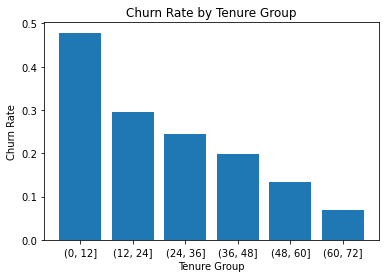

In [47]:
#Plotting the relationship
x = churn_rate_by_tenure.index.astype(str)
y = churn_rate_by_tenure.values

plt.bar(x, y)
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Tenure Group')
plt.show()


The Churn rate is decreasing as tenure increases, this suggests that customers with longer tenures are less likely to churn. Therefore, as customers stay with the company for a longer period of time, their likelihood of churn decreases.
This decreasing trend can be seen as a positive sign for the company, as it indicates that customer loyalty tends to increase with longer tenures. This implies that customers who have been with the company for a while are more satisfied with the services or products provided, and are less likely to switch to a competitor.

### 3. Does the type of internet service influence customer churn?

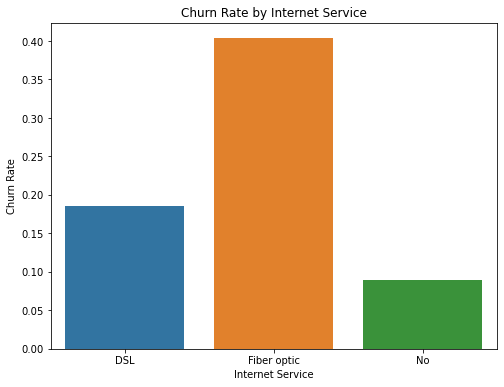

In [48]:
# Group the data by InternetService and calculate churn rate
churn_by_internet_service = train.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack()
churn_by_internet_service = churn_by_internet_service.loc[:, 'Yes']

# Plotting the churn rates for each internet service category
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_by_internet_service.index, y=churn_by_internet_service.values)
plt.xlabel('Internet Service')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Internet Service')
plt.show()


Based on the graph above, it can be observed that customers who had fiber optic internet service had the highest churn rate, followed by those who had DSL, and the lowest churn rate was among those who did not have internet services.
This could be due to the Service Quality of the Internet service. Fiber optic internet service is typically associated with higher speeds and better performance compared to DSL. However, if the quality of the fiber optic service provided by the telecom company is not up to the customers' expectations or if there are frequent disruptions or outages, it could lead to customer dissatisfaction and ultimately churn.
In addition, the high churn rate by the people using fiber optic could be due to the pricig. Fiber optic internet service is often priced higher than DSL, which may attract customers initially due to the perceived benefits of faster speeds. However, if customers feel that the higher cost does not justify the value they are receiving or if they find alternative providers offering similar services at a lower price, they may choose to switch and churn.
FOr the low churn rate by customers with no internet service could be due to the customers having access to alternative internet sources like public Wi-Fi or using mobile data. Since they are not relying on the telecom company for internet services, they may have lower churn rates.


## 4. Is there a correlation between the customer's payment method and churn rate?

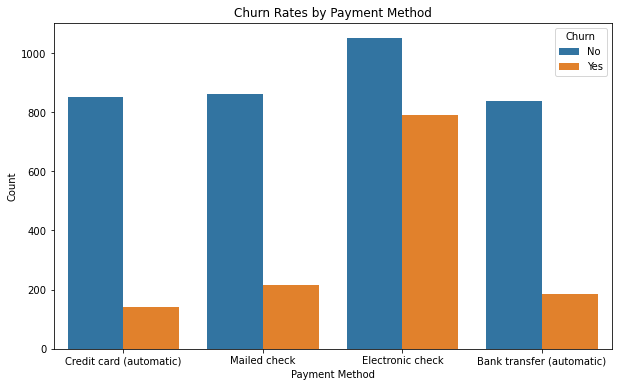

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=train)
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.title('Churn Rates by Payment Method')
plt.show()


Based on the graph of the churn rates by payment method, it appears that there is a correlation between the customer's payment method and churn rate.

Among the customers who churned, the highest number of churned customers used the electronic check as their payment method, followed by those who used the mailed check. This indicates that customers who use electronic check may have a higher likelihood of churning compared to other payment methods.

On the other hand, customers who used bank transfer (automatic) or credit card (automatic) as their payment method had relatively lower churn rates compared to those using electronic check or mailed check.

### 5. Does the presence of paperless billing affect customer churn?

In [50]:
churn_by_paperless = train.groupby('PaperlessBilling')['Churn'].value_counts(normalize=True).unstack()
churn_by_paperless.transpose()

PaperlessBilling,No,Yes
Churn,,
No,0.831924,0.666886
Yes,0.168076,0.333114


## Hypothesis Testing

Null Hypothesis: There is no significant relationship between the customer's internet service provider and their likelihood of churn

Alterntive Hypothesis : There is a significant relationship between the Customer's internet service provider and their likelihood of churn

In [51]:
# Create the contingency table
contingency_table = [[0.831924, 0.666886], [0.168076, 0.333114]]

# Perform the chi-square test
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

# Compare the p-value with the significance level
if p_value < 0.05:
    print("There is a significant relationship between the customer's internet service provider and their likelihood of churn.")
else:
    print("There is no significant relationship between the customer's internet service provider and their likelihood of churn.")


There is no significant relationship between the customer's internet service provider and their likelihood of churn.


We do not to reject the null hypothesis. This means that the customer's internet service provider is not a significant factor in determining their likelihood of churn.

## Feature Engineering

<AxesSubplot:>

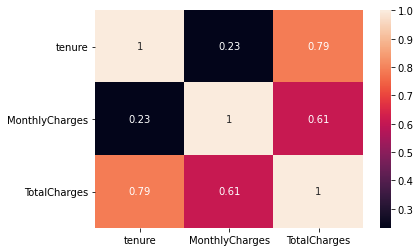

In [52]:
sns.heatmap(train.corr(),annot=True)

In [53]:
train.isna().sum()

gender                0
SeniorCitizen       229
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 0
dtype: int64

## Feature Encoding

In [54]:
#Encoding the target column
# Perform label encoding on 'Churn' column
label_encoder = LabelEncoder()
train['Churn'] = label_encoder.fit_transform(train['Churn'])

In [55]:
train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4930 entries, 4097 to 3578
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4930 non-null   object 
 1   SeniorCitizen     4701 non-null   object 
 2   Partner           4930 non-null   object 
 3   Dependents        4930 non-null   object 
 4   tenure            4930 non-null   float64
 5   PhoneService      4930 non-null   object 
 6   MultipleLines     4930 non-null   object 
 7   InternetService   4930 non-null   object 
 8   OnlineSecurity    4930 non-null   object 
 9   OnlineBackup      4930 non-null   object 
 10  DeviceProtection  4930 non-null   object 
 11  TechSupport       4930 non-null   object 
 12  StreamingTV       4930 non-null   object 
 13  StreamingMovies   4930 non-null   object 
 14  Contract          4930 non-null   object 
 15  PaperlessBilling  4930 non-null   object 
 16  PaymentMethod     4930 non-null   objec

In [57]:
# Dividing numerical and categorical columns
numerical_columns = train.select_dtypes(include=['int64', 'float64','int32']).columns
categorical_columns = train.select_dtypes(include=['object']).columns

# Subset of the numerical columns
train_num = train[numerical_columns]

# A subset of the categorical columns
train_cat = train[categorical_columns]
# Convert boolean columns to strings
train_cat = train_cat.astype(str)
#THe shape of each
train_num.shape,train_cat.shape

((4930, 4), (4930, 16))

In [58]:
#Numerical columns
print(f"The numerical columns in the train dataset are:",train_num.columns)

#Categorical columns
print(f"\nThe categorical columns in the train dataset are:",train_cat.columns)

The numerical columns in the train dataset are: Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')

The categorical columns in the train dataset are: Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [59]:
#from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False,drop='first',handle_unknown='error').set_output(transform='pandas')
encoder.fit(train_cat)
encoded_data = encoder.transform(train_cat)
#encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(),index=train_cat.index)
#encoded_df
encoded_data

,gender_Male,SeniorCitizen_Yes,SeniorCitizen_nan,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4097,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1688,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6215,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5586,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5668,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6683,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2688,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2656,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [60]:
encoded_data

,gender_Male,SeniorCitizen_Yes,SeniorCitizen_nan,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4097,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1688,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6215,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5586,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5668,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6683,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2688,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2656,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [61]:
encoded_data.shape

(4930, 21)

In [62]:
encoded_data.columns

Index(['gender_Male', 'SeniorCitizen_Yes', 'SeniorCitizen_nan', 'Partner_Yes',
       'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [63]:
encoded_train = pd.concat([train_num, encoded_data], axis=1)
encoded_train

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_Yes,SeniorCitizen_nan,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4097,64.0,65.504322,6171.200000,0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1688,40.0,20.150000,804.850000,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6215,6.0,65.504322,560.600000,1,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,72.0,24.450000,1709.100000,0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5586,27.0,19.150000,501.350000,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5668,39.0,101.250000,2280.414548,0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6683,43.0,44.150000,1931.300000,0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2688,5.0,78.750000,412.100000,1,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2656,39.0,59.300000,2209.150000,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


## Handling Imbalanced Data using SMOTE


In [64]:
# Splitting the dataset into features (X) and target variable (y)
X = encoded_train.drop('Churn', axis=1)
y = encoded_train['Churn']

In [65]:

#Cloning the class SMOTE and specifying the sampling strategy
smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled= smote.fit_resample(X, y)

#
y_resampled.value_counts()

0    3600
1    3600
Name: Churn, dtype: int64

In [66]:
print(X_resampled.shape)
print(y_resampled.shape)


(7200, 24)
(7200,)


## Data Splitting

In [67]:
#from sklearn.model_selection import train_test_split
# Split the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42,stratify=y_resampled)


In [68]:
X_train.shape,X_eval.shape,y_train.shape,y_eval.shape

((5760, 24), (1440, 24), (5760,), (1440,))

### Scaling

In [69]:
#Cloning the standardscaler class
scaler =StandardScaler().set_output(transform="pandas")
# Columns to be scaled
columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
#Fitting and transforming the selected columns in the training data set
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale]=scaler.fit_transform(X_train[columns_to_scale])

#Transforming the selected columns  in the evaluation dataset
X_eval_scaled=X_eval.copy() #TO create a copy
X_eval_scaled[columns_to_scale] = scaler.transform(X_eval[columns_to_scale])

In [70]:
#Checking on the scaled training set
X_train_scaled.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,SeniorCitizen_nan,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
908,0.259274,-1.386258,-0.537648,1.000000,0.000000,1.0,1.0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0
7082,-0.142158,0.874482,0.022329,1.000000,0.218197,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.781803,0.781803,0.781803,0.000000,0.000000,1.0,0.0,1.0,0.0
1586,-0.213230,0.477012,-0.125038,0.000000,0.000000,0.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,0.0,0.0
5542,0.702598,1.299195,1.633925,0.528214,0.528214,0.0,0.0,0.0,1.0,1.0,...,0.528214,0.471786,1.000000,1.000000,0.528214,0.471786,1.0,0.0,1.0,0.0
1203,0.903599,1.268313,1.400823,1.000000,0.000000,0.0,0.0,0.0,1.0,1.0,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,0.0,0.0,0.0


In [71]:
#To check on the scaled evaluation on the predictor set
X_eval_scaled.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,SeniorCitizen_nan,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4181,-0.470960,-1.739355,-0.825298,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2761,0.517004,-1.757463,-0.613954,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4246,-1.201195,-1.569144,0.097099,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1571,-0.256185,0.381042,-0.157254,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
619,1.719743,1.118020,2.172729,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


### Modelling

In [72]:
# Defining a list of models that will be evaluated
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('LightGBM', LGBMClassifier(random_state=42)),
]

# Initializing an empty dataframe that will store the evaluation scores
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

# Iterate over the models and train, evaluate, and store the results
for model_name, model in models:
    # Fitting the models to the training dataset
    model.fit(X_train_scaled, y_train)

    # Make predictions using the evaluation dataset
    y_pred = model.predict(X_eval_scaled)

    # Calculate performance metrics
    accuracy = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred)
    recall = recall_score(y_eval, y_pred)
    f1 = f1_score(y_eval, y_pred)
    auc_roc = roc_auc_score(y_eval, y_pred)

    # Store the results in the dataframe
    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc
    }, ignore_index=True)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2880, number of negative: 2880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4882
[LightGBM] [Info] Number of data points in the train set: 5760, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [73]:
#Evaluation scores dataframe
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Logistic Regression,0.760417,0.755102,0.770833,0.762887,0.760417
1,Random Forest,0.853472,0.873715,0.826389,0.849393,0.853472
2,Gradient Boosting,0.845833,0.856734,0.830556,0.843441,0.845833
3,Support Vector Machine,0.820833,0.827195,0.811111,0.819074,0.820833
4,Gaussian Naive Bayes,0.756944,0.750678,0.769444,0.759945,0.756944
5,K-Nearest Neighbors,0.772917,0.720045,0.893056,0.797272,0.772917
6,Decision Tree,0.798611,0.807143,0.784722,0.795775,0.798611
7,XGBoost,0.840278,0.856105,0.818056,0.836648,0.840278
8,LightGBM,0.850694,0.869693,0.825000,0.846757,0.850694


## Hyperparameter Tuning


#### Hyperparameter Tuning for the Random Forest Model

In [74]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [76]:
# Defining the parameter grid for Random Forest m
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5,10, 12],
    'min_samples_leaf': [1, 2,4, 8]
}


In [77]:
# Defining a random forest model
rf = RandomForestClassifier(random_state=42)
#Perfoming a grid search using cross validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='f1', cv=5)
grid_search_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 50],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 12],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='f1')

In [78]:
# Getting the best parameters
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

In [79]:
#Displaying the best parameters
print(f"The best hyperparameters for the Random Forest model are:\n{best_params_rf}")

The best hyperparameters for the Random Forest model are:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


#### Hyperparameter Tuning for The LightGBM model

In [80]:
# Defining the parameter grid for LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.01, 0.001]
}


In [81]:
# Creating a LightGBM classifier
lgbm = LGBMClassifier(random_state=42)

# Performing Grid Search Cross Validation
grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, scoring='f1', cv=5)
grid_search_lgbm.fit(X_train_scaled, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2304, number of negative: 2304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4655
[LightGBM] [Info] Number of data points in the train set: 4608, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [82]:
# Getting the best parameters and best F1 score
best_params_lgbm = grid_search_lgbm.best_params_
best_score_lgbm = grid_search_lgbm.best_score_


In [83]:
#Printing the best hyperparameters
print(f"The best hyperparameters for the light gbm model are:\n{best_params_lgbm}")

The best hyperparameters for the light gbm model are:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


#### Hyperparameter Tuning on the Catboost Model

In [84]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

In [85]:
# Define the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)


In [86]:
# Performing Grid Search with cross-validation
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [87]:
# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_gb = grid_search.best_estimator_ 

In [88]:
print(f"The best hyperparameters for the Gradient boosting classifier are: \n{best_params}")

The best hyperparameters for the Gradient boosting classifier are: 
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


  ### Perfomance Comparison after Hyperparameter Tuning

In [89]:
# Initialize an empty dataframe to store the evaluation scores
results_tuned_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

# Define the models with the best hyperparameters
# rf_model_tuned = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)
# lgbm_model_tuned = LGBMClassifier(learning_rate=0.1, n_estimators=200, max_depth=5, random_state=42)
# gb_model_tuned = GradientBoostingClassifier(random_state=42,learning_rate=0.1,max_depth=3,n_estimators=100)

rf_model_tuned = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=1, random_state=42)
lgbm_model_tuned = LGBMClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)
gb_model_tuned = GradientBoostingClassifier(random_state=42,learning_rate=0.1,max_depth=3,n_estimators=100)
# Fit the tuned models to the training data
rf_model_tuned.fit(X_train_scaled, y_train)
lgbm_model_tuned.fit(X_train_scaled, y_train)
gb_model_tuned.fit(X_train_scaled,y_train)


# Make predictions on the evaluation data
y_pred_rf = rf_model_tuned.predict(X_eval_scaled)
y_pred_lgbm = lgbm_model_tuned.predict(X_eval_scaled)
y_pred_gb =gb_model_tuned.predict(X_eval_scaled)

# Calculate the evaluation scores
accuracy_rf = accuracy_score(y_eval, y_pred_rf)
precision_rf = precision_score(y_eval, y_pred_rf)
recall_rf = recall_score(y_eval, y_pred_rf)
f1_rf = f1_score(y_eval, y_pred_rf)
auc_roc_rf = roc_auc_score(y_eval, y_pred_rf)

accuracy_lgbm = accuracy_score(y_eval, y_pred_lgbm)
precision_lgbm = precision_score(y_eval, y_pred_lgbm)
recall_lgbm = recall_score(y_eval, y_pred_lgbm)
f1_lgbm = f1_score(y_eval, y_pred_lgbm)
auc_roc_lgbm = roc_auc_score(y_eval, y_pred_lgbm)

accuracy_gb = accuracy_score(y_eval, y_pred_gb)
precision_gb = precision_score(y_eval, y_pred_gb)
recall_gb = recall_score(y_eval, y_pred_gb)
f1_gb = f1_score(y_eval, y_pred_gb)
auc_roc_gb = roc_auc_score(y_eval, y_pred_gb)

# Adding the results to the dataframe
results_tuned_df = results_tuned_df.append({'Model': 'Random Forest (Tuned)',
                                'Accuracy': accuracy_rf,
                                'Precision': precision_rf,
                                'Recall': recall_rf,
                                'F1 Score': f1_rf,
                                'AUC-ROC': auc_roc_rf}, ignore_index=True)

results_tuned_df = results_tuned_df.append({'Model': 'LightGBM (Tuned)',
                                'Accuracy': accuracy_lgbm,
                                'Precision': precision_lgbm,
                                'Recall': recall_lgbm,
                                'F1 Score': f1_lgbm,
                                'AUC-ROC': auc_roc_lgbm}, ignore_index=True)

results_tuned_df = results_tuned_df.append({'Model': 'Gradient Boosting (Tuned)',
                                'Accuracy': accuracy_gb,
                                'Precision': precision_gb,
                                'Recall': recall_gb,
                                'F1 Score': f1_gb,
                                'AUC-ROC': auc_roc_gb}, ignore_index=True)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2880, number of negative: 2880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4882
[LightGBM] [Info] Number of data points in the train set: 5760, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [90]:
#Evaluation scores for the tuned models
results_tuned_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Random Forest (Tuned),0.853472,0.858956,0.845833,0.852344,0.853472
1,LightGBM (Tuned),0.848611,0.865889,0.825000,0.844950,0.848611
2,Gradient Boosting (Tuned),0.845833,0.856734,0.830556,0.843441,0.845833


In [91]:
#Evaluation scores for the untuned models
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Logistic Regression,0.760417,0.755102,0.770833,0.762887,0.760417
1,Random Forest,0.853472,0.873715,0.826389,0.849393,0.853472
2,Gradient Boosting,0.845833,0.856734,0.830556,0.843441,0.845833
3,Support Vector Machine,0.820833,0.827195,0.811111,0.819074,0.820833
4,Gaussian Naive Bayes,0.756944,0.750678,0.769444,0.759945,0.756944
5,K-Nearest Neighbors,0.772917,0.720045,0.893056,0.797272,0.772917
6,Decision Tree,0.798611,0.807143,0.784722,0.795775,0.798611
7,XGBoost,0.840278,0.856105,0.818056,0.836648,0.840278
8,LightGBM,0.850694,0.869693,0.825000,0.846757,0.850694


### Feature Importance


In [92]:
# Get feature importances from the Random Forest model
feature_importances = rf_model_tuned.feature_importances_

# Create a dataframe to store the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe by feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance dataframe
feature_importance_df


,Feature,Importance
22,PaymentMethod_Electronic check,0.116032
0,tenure,0.112994
19,Contract_Two year,0.085817
2,TotalCharges,0.075412
10,InternetService_Fiber optic,0.072662
20,PaperlessBilling_Yes,0.060882
1,MonthlyCharges,0.059796
12,OnlineSecurity_Yes,0.058153
15,TechSupport_Yes,0.057634
18,Contract_One year,0.057149


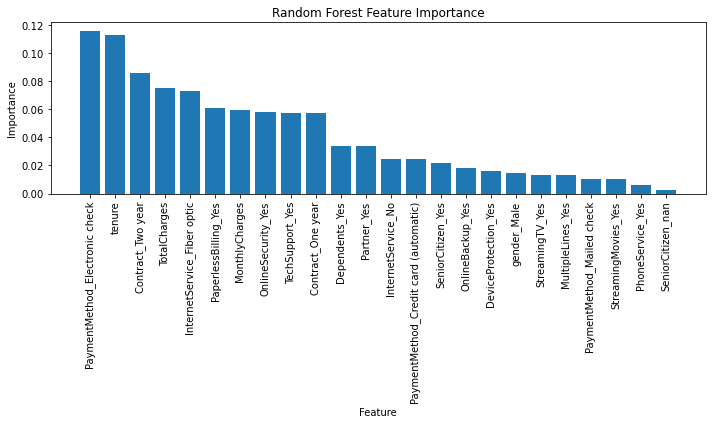

In [93]:
# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


## Random Forest model without Senior Citizen Column

In [94]:
#Defining our tuned model 
rf_model_tuned_Sn = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=42)

### Saving the Model

In [95]:

final_model = 'Churn_Model1.pkl'

pickle.dump(rf_model_tuned_Sn,open('final_model','wb'))

In [96]:
#Loading the Model
final_model = pickle.load(open('final_model','rb'))

In [97]:
final_model

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)

### Expoting the Key Components

#### Requirements

In [98]:
#Requirements file
!pip freeze > requirements.txt

### Object to Export

In [99]:
components = {
    'label_encoder': label_encoder,
    'encoder': encoder,
    'scaler': scaler,
    'imbalance': smote,
    'grid_search_rfc':grid_search_rf,
    'model': rf_model_tuned_Sn
}

### Exporting the Model

In [100]:
with open ('ML_Model1.pkl', 'wb') as file:
    pickle.dump(components, file)

### Loading After Exporting the Model

In [101]:
with open ('ML_Model1.pkl', 'rb') as file:
    loaded_object = pickle.load(file)

In [102]:
#Checking on the Loaded objects
loaded_object

{'label_encoder': LabelEncoder(),
 'encoder': OneHotEncoder(drop='first', sparse=False, sparse_output=False),
 'scaler': StandardScaler(),
 'imbalance': SMOTE(sampling_strategy='minority'),
 'grid_search_rfc': GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
              param_grid={'max_depth': [None, 10, 20, 50],
                          'min_samples_leaf': [1, 2, 4, 8],
                          'min_samples_split': [2, 5, 10, 12],
                          'n_estimators': [100, 200, 300, 500]},
              scoring='f1'),
 'model': RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)}

### Conclusion

Customer churn presents a substantial challenge in the telecommunications industry, with many customers discontinuing services. The analysis of Vodafone’s customer data reveals several key insights:

- **Tenure**: Churn rates decline as customer tenure lengthens, indicating that long-term customers are less likely to leave. This pattern suggests that loyalty and satisfaction tend to grow over time, reflecting a stronger relationship with the company.

- **Payment Method**: The type of payment method correlates with churn rates. Customers using electronic or mailed checks show higher churn rates, while those who use bank transfers or credit cards with automatic payments exhibit lower churn rates. This pattern suggests that convenient, automated payment options may enhance satisfaction and loyalty.

- **Paperless Billing**: Customers who choose paperless billing show a higher churn rate than those preferring traditional billing methods. This suggests that customers who opt for digital processes may have unique expectations or experiences that impact their decision to stay or leave.

These insights can help inform strategies to reduce churn by focusing on factors that influence customer retention and loyalty.

### Recommendations

1. **Prioritize Retention Strategies for New Customers**: Since customers with longer tenures are less prone to churn, it’s essential to focus on boosting satisfaction and engagement early in the customer relationship. Strategies could include providing personalized onboarding, exceptional customer service, and loyalty incentives to foster commitment from the start.

2. **Offer Incentives for Automated Payments**: Encourage customers to set up automated payments through bank transfer or credit card by offering perks like discounts or rewards. This not only adds convenience for the customer but also reinforces loyalty.

3. **Enhance the Paperless Billing Experience**: Identify and address any challenges or reservations customers may have about paperless billing. Improve the interface, clearly communicate billing details, and consider offering rewards or additional benefits for customers who opt for paperless billing.

4. **Conduct Customer Satisfaction Surveys**: Regularly gather feedback from customers to gain insights into their needs, preferences, and satisfaction. This feedback can highlight areas for improvement and allow the company to proactively address any concerns.

5. **Implement Targeted Marketing Campaigns**: Focus on educating customers about the benefits of the company’s services, addressing common challenges, and promoting the advantages of a long-term relationship with the company.

6. **Regularly Update the Churn Prediction Model**: Customer churn patterns can change over time, so it's important to continually monitor and update the predictive model with new data. This ensures the model remains accurate and effective at forecasting churn.